In [1]:
import os

import fitsio
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from pandas import read_csv

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Read the Open Supernova Catalog

In [3]:
allosc = read_csv('osc.csv')
nallosc = len(allosc)
print('Read {} supernovae in OSC catalog.'.format(nallosc))

Read 41133 supernovae in OSC catalog.


In [4]:
allosc

,Name,Disc. Date,mmax,Host Name,R.A.,Dec.,z,Type,Phot.,Spec.,Radio,X-ray
0,SN1987A,1987/02/24,1.90,LMC,"05:35:28.020,05:35:28,05:35:28.01,05:35:27.99","-69:16:11.07,-69:16:11,-69:16:11.61,-69:16:11....","9.51e-06,9.78e-06,1.02e-05,1.06e-05,1.07e-05,1...",II Pec,3332.0,36.0,NaN,105.0
1,SN2003dh,2003/03/31,12.62,A104450+2131,"10:44:50.030,10:44:50.01,10:44:50.018","+21:31:18.15,+21:31:17.8,+21:31:17.80,+21:31:1...",0.1685,Ic BL,2781.0,13.0,NaN,NaN
2,SN2011fe,2011/08/24,9.48,NGC 5457,"14:03:05.711,14:03:05.76,14:03:05.81,14:03:05.80","+54:16:25.22,+54:16:25.32,+54:16:25.4,+54:16:2...",0.000804,Ia,2728.0,80.0,0.0,0.0
3,SN1993J,1993/03/28,9.91,NGC 3031,"09:55:24.7747,09:55:24.95,09:55:25.00","+69:01:13.702,+69:01:13.38,+69:01:13.01,+69:01...",-0.000113,IIb,1814.0,50.0,NaN,NaN
4,SN2002ap,2002/01/29,12.04,NGC 628,"01:36:23.85,01:36:23.87","+15:45:13.2,+15:45:13.21,+15:45:13.0",0.002108,Ic BL,1781.0,39.0,NaN,NaN
5,SN2009ip,2012/07/24,12.01,NGC 7259,"22:23:08.3,22:23:08.26","-28:56:52,-28:56:52.4,-28:56:52.40",0.005944,LBV to IIn,1569.0,240.0,NaN,NaN
6,SN2011dh,2011/06/01,12.06,NGC 5194,"13:30:05.1055,13:30:05.12,13:30:05.124","+47:10:10.922,+47:10:11.3,+47:10:10.81,+47:10:...",0.001638,IIb,1333.0,71.0,NaN,NaN
7,SN2000cx,2000/07/17,12.90,NGC 524,"01:24:46.19,01:24:46.15","+09:30:31.3,+09:30:30.9,+09:30:30.89","0.007929,0.008076",Ia Pec,1316.0,45.0,NaN,NaN
8,SN1999em,1999/10/29,12.80,NGC 1637,"04:41:27.04,04:41:27.168,04:41:27.13,04:41:27.05","-02:51:45.2,-02:51:45.828,-02:51:45.4,-02:51:4...",0.002392,II P,1207.0,72.0,NaN,NaN
9,SN1999ee,1999/10/07,14.50,IC 5179,"22:16:09.40,22:16:10.00","-36:50:31.5,-36:50:39.7,-36:50:39.70","0.01141,0.01141",Ia,1169.0,26.0,NaN,NaN


Since we're going to be matching against the SDSS database, we probably only want objects whose host galaxy name is populated (maybe)?

In [5]:
keep = ['nan' not in str(hostname).lower() for hostname in allosc['Host Name']]
#keep = np.where(['nan' not in str(hostname).lower() for hostname in allosc['Host Name']])[0]
nosc = int(np.sum(keep))
print('Keeping {} OSC supernovae with known host galaxies.'.format(nosc))
osc = allosc[keep]
osc = osc.reset_index(drop=True)

Keeping 16838 OSC supernovae with known host galaxies.


### Loop on each supernova and get the mean coordinates.

In [6]:
def _hms(ra):
    """Convert RA in hms to decimal degrees."""
    sep1 = ra.find(':')
    hh = int( ra[0:sep1] )
    sep2 = ra[sep1+1:].find(':')
    if sep2 == -1:
        mm = float( ra[sep1+1:] )
        ss = 0.0
    else:
        mm = int( ra[sep1+1:sep1+sep2+1] )
        ss = float( ra[sep1+sep2+2:] )
    return hh*15.0 + mm/4.0 + ss/240.0

In [7]:
def _dms(dec):
    """Convert Dec in dms to decimal degrees."""
    Csign = dec[0]
    if Csign == '-':
        sign = -1.0
        off = 1
    elif Csign == '+':
        sign = 1.0
        off = 1
    else:
        sign = 1.0
        off = 0
    sep1 = dec.find(':')
    deg = int( dec[off:sep1] )
    sep2 = dec[sep1+1:].find(':')
    if sep2 == -1:
        arcmin = float( dec[sep1+1:] )
        arcsec = 0.0
    else:
        arcmin = int( dec[sep1+1:sep1+sep2+1] )
        arcsec = float( dec[sep1+sep2+2:] )
    
    return sign * (deg + (arcmin*5.0/3.0 + arcsec*5.0/180.0) / 100.0)

In [8]:
ra, dec, good = np.zeros(nosc), np.zeros(nosc), np.ones(nosc).astype(bool)
for ii in range(nosc):
    sra = str(osc['R.A.'][ii]).split(',')
    sdec = str(osc['Dec.'][ii]).split(',')
    if 'nan' in sra:
        good[ii] = False
        continue
    nn = len(sra)
    ra1 = np.zeros(nn)
    dec1 = np.zeros(nn)
    for jj, (rr, dd) in enumerate(zip(sra, sdec)):
        #print(ii, rr, dd)
        if ':' in rr:
            ra1[jj] = _hms(rr)
            dec1[jj] = _dms(dd)
        else:
            ra1[jj] = rr
            dec1[jj] = dd
    ra[ii] = np.mean(ra1)
    dec[ii] = np.mean(dec1)

In [9]:
oscgood = Table.from_pandas(osc[good])
noscgood = len(oscgood)
print('Found {} OSC supernovae with good coordinates.'.format(noscgood))

Found 16823 OSC supernovae with good coordinates.


In [10]:
oscgood.add_column(Column(ra[good], name='MEAN_RA'))
oscgood.add_column(Column(dec[good], name='MEAN_DEC'))

In [11]:
oscgood

Name,Disc. Date,mmax,Host Name,R.A.,Dec.,z,Type,Phot.,Spec.,Radio,X-ray,MEAN_RA,MEAN_DEC
str30,str21,float64,str30,str106,str146,str125,str19,float64,float64,float64,float64,float64,float64
SN1987A,1987/02/24,1.9,LMC,"05:35:28.020,05:35:28,05:35:28.01,05:35:27.99","-69:16:11.07,-69:16:11,-69:16:11.61,-69:16:11.50,-69:16:11.5,-69:16:11.6,+05:35:28.020","9.51e-06,9.78e-06,1.02e-05,1.06e-05,1.07e-05,1.11e-05,1.12e-05,1.13e-05,1.14e-05,1.15e-05,1.16e-05,1.17e-05,1.19e-05,1.22e-05",II Pec,3332.0,36.0,--,105.0,83.8666875,-69.2698041667
SN2003dh,2003/03/31,12.62,A104450+2131,"10:44:50.030,10:44:50.01,10:44:50.018","+21:31:18.15,+21:31:17.8,+21:31:17.80,+21:31:17.89",0.1685,Ic BL,2781.0,13.0,--,--,161.208413889,21.5216435185
SN2011fe,2011/08/24,9.48,NGC 5457,"14:03:05.711,14:03:05.76,14:03:05.81,14:03:05.80","+54:16:25.22,+54:16:25.32,+54:16:25.4,+54:16:25.39,+54:16:25.3",0.000804,Ia,2728.0,80.0,0.0,0.0,210.774042708,54.2737034722
SN1993J,1993/03/28,9.91,NGC 3031,"09:55:24.7747,09:55:24.95,09:55:25.00","+69:01:13.702,+69:01:13.38,+69:01:13.01,+69:01:13.0,+69:01:13.4",-0.000113,IIb,1814.0,50.0,--,--,148.853784306,69.0203788889
SN2002ap,2002/01/29,12.04,NGC 628,"01:36:23.85,01:36:23.87","+15:45:13.2,+15:45:13.21,+15:45:13.0",0.002108,Ic BL,1781.0,39.0,--,--,24.0994166667,15.7536680556
SN2009ip,2012/07/24,12.01,NGC 7259,"22:23:08.3,22:23:08.26","-28:56:52,-28:56:52.4,-28:56:52.40",0.005944,LBV to IIn,1569.0,240.0,--,--,335.7845,-28.9478333333
SN2011dh,2011/06/01,12.06,NGC 5194,"13:30:05.1055,13:30:05.12,13:30:05.124","+47:10:10.922,+47:10:11.3,+47:10:10.81,+47:10:11.301",0.001638,IIb,1333.0,71.0,--,--,202.52131875,47.1697251852
SN2000cx,2000/07/17,12.9,NGC 524,"01:24:46.19,01:24:46.15","+09:30:31.3,+09:30:30.9,+09:30:30.89","0.007929,0.008076",Ia Pec,1316.0,45.0,--,--,21.192375,9.50863888889
SN1999em,1999/10/29,12.8,NGC 1637,"04:41:27.04,04:41:27.168,04:41:27.13,04:41:27.05","-02:51:45.2,-02:51:45.828,-02:51:45.4,-02:51:45.22,-02:51:45.8",0.002392,II P,1207.0,72.0,--,--,70.3629041667,-2.86261444444


For reference, here are the SNe with bad or no coordinates.

In [12]:
osc[~good]

,Name,Disc. Date,mmax,Host Name,R.A.,Dec.,z,Type,Phot.,Spec.,Radio,X-ray
973,SNLS-04D4fu,2004/10/19,21.57,APMUKS(BJ) B221128.89-174722.6,NaN,NaN,"0.133,0.133,0.144",NaN,55.0,NaN,NaN,NaN
1475,SNLS-04D1pj,2004/12/13,21.43,XMDS J022649.3-041154,NaN,NaN,"0.1556,0.1556",NaN,38.0,NaN,NaN,NaN
3350,SNLS-03D4cw,2003/08/27,22.11,APMUKS(BJ) B221331.31-172920.9,NaN,NaN,"0.1543,0.1543",NaN,18.0,NaN,NaN,NaN
14740,PS10r,2010,NaN,SDSS J104438.19+574839.8,NaN,NaN,0.1188,NaN,NaN,NaN,NaN,NaN
14741,PS10v,2010,NaN,SDSS J100325.83+010143.3,NaN,NaN,0.0996,NaN,NaN,NaN,NaN,NaN
14742,PS10z,2010,NaN,PS1 J083612.60+440025.5,NaN,NaN,0.1406,NaN,NaN,NaN,NaN,NaN
16787,SDSS-II SN 10030,NaN,NaN,2MASX J01154483+0014005,NaN,NaN,0.044337,NaN,NaN,NaN,NaN,NaN
16788,SDSS-II SN 10121,NaN,NaN,NGC 7398,NaN,NaN,0.015718,NaN,NaN,NaN,NaN,NaN
16789,SDSS-II SN 14386,NaN,NaN,MCG +00-04-045,NaN,NaN,0.044344,NaN,NaN,NaN,NaN,NaN
16790,SDSS-II SN 15199,NaN,NaN,SDSS J205236.96-002715.0,NaN,NaN,0.4199,NaN,NaN,NaN,NaN,NaN


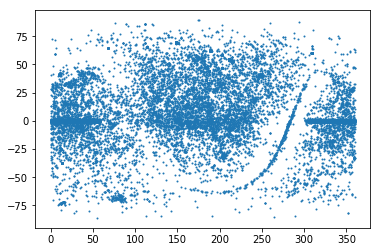

In [13]:
fig, ax = plt.subplots()
ax.scatter(oscgood['MEAN_RA'], oscgood['MEAN_DEC'], s=1)

### Read the SDSS galspecinfo catalog and match.

In [14]:
_sdssinfo = fitsio.FITS('galSpecInfo-dr8.fits')
print(_sdssinfo[1])
cols = ['SPECOBJID', 'RA', 'DEC', 'PLATEID', 'MJD', 'FIBERID', 'Z']
sdssinfo = Table(_sdssinfo[1].read(columns=cols))


  file: galSpecInfo-dr8.fits
  extension: 1
  type: BINARY_TBL
  rows: 1843200
  column info:
    SPECOBJID          S19  
    RELIABLE            i2  
    PLATEID             i2  
    MJD                 i4  
    FIBERID             i2  
    PHOTOID             i2  array[5]
    RA                  f4  
    DEC                 f4  
    PLUG_MAG            f4  array[5]
    PRIMTARGET          i2  
    SECTARGET           i2  
    TARGETTYPE         S19  
    SPECTROTYPE         S6  
    SUBCLASS           S21  
    Z                   f4  
    Z_ERR               f4  
    Z_WARNING           i2  
    V_DISP              f4  
    V_DISP_ERR          f4  
    SN_MEDIAN           f4  
    E_BV_SFD            f4  
    ZTWEAK              f4  
    ZTWEAK_ERR          f4  
    SPECTRO_MAG         f4  array[3]
    KCOR_MAG            f4  array[3]
    KCOR_MODEL_MAG      f4  array[5]
    RELEASE            S12  


In [15]:
_sdssprops = fitsio.FITS('galSpecExtra-dr8.fits')
print(_sdssprops[1])
cols = ['LGM_TOT_P50', 'OH_P50', 'SFR_TOT_P50', 'SPECSFR_TOT_P50', 'BPTCLASS']
sdssprops = Table(_sdssprops[1].read(columns=cols))


  file: galSpecExtra-dr8.fits
  extension: 1
  type: BINARY_TBL
  rows: 1843200
  column info:
    SPECOBJID          S19  
    PLATEID             i4  
    MJD                 i4  
    FIBERID             i4  
    BPTCLASS            i2  
    LGM_TOT_P2P5        f4  
    LGM_TOT_P16         f4  
    LGM_TOT_P50         f4  
    LGM_TOT_P84         f4  
    LGM_TOT_P97P5       f4  
    LGM_FIB_P2P5        f4  
    LGM_FIB_P16         f4  
    LGM_FIB_P50         f4  
    LGM_FIB_P84         f4  
    LGM_FIB_P97P5       f4  
    OH_P2P5             f4  
    OH_P16              f4  
    OH_P50              f4  
    OH_P84              f4  
    OH_P97P5            f4  
    OH_ENTROPY          f4  
    SFR_TOT_P2P5        f4  
    SFR_TOT_P16         f4  
    SFR_TOT_P50         f4  
    SFR_TOT_P84         f4  
    SFR_TOT_P97P5       f4  
    SFR_TOT_ENTROPY     f4  
    SFR_FIB_P2P5        f4  
    SFR_FIB_P16         f4  
    SFR_FIB_P50         f4  
    SFR_FIB_P84         f4  
    S

Toss out galaxies with RA, Dec coordinates equal to -9999 and also require a stellar mass.

In [16]:
sdssgood = np.where( (sdssinfo['RA'] >= 0) * (sdssinfo['RA'] <= 360) *
                    (sdssprops['LGM_TOT_P50'] > 0) )[0]
sdssinfo = sdssinfo[sdssgood]
sdssprops = sdssprops[sdssgood]
print('Read {} SDSS galaxies with good coordinates and stellar masses.'.format(len(sdssinfo)))

Read 982270 SDSS galaxies with good coordinates and stellar masses.


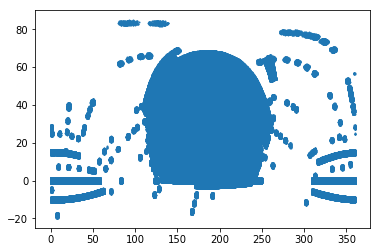

In [17]:
fig, ax = plt.subplots()
ax.scatter(sdssinfo['RA'], sdssinfo['DEC'], s=1)

In [18]:
scoord = SkyCoord(ra=sdssinfo['RA']*u.deg, dec=sdssinfo['DEC']*u.deg)
ocoord = SkyCoord(ra=oscgood['MEAN_RA']*u.deg, dec=oscgood['MEAN_DEC']*u.deg)
_, sep2d, _ = ocoord.match_to_catalog_sky(scoord)

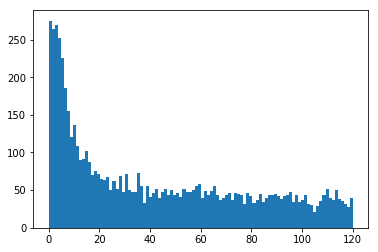

In [19]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(sep2d.arcsec, bins=100, range=(0, 120))

### Just keep the matches within 10 arcsec, but this isn't quite right.  We should really take into account the size of the host galaxy and a myriad other issues.  Also note that some objects are duplicated.

In [20]:
rad = 10.0 * u.arcsec
indx_sdss, indx_osc, d2d, _ = ocoord.search_around_sky(scoord, rad)
nmatch = len(indx_sdss)
print('Found {} matches within {}'.format(nmatch, rad))

Found 2085 matches within 10.0 arcsec


In [21]:
len(indx_sdss), len(indx_osc), indx_sdss.max(), indx_osc.max(), len(np.unique(indx_sdss))

(2085, 2085, 978257, 16809, 2044)

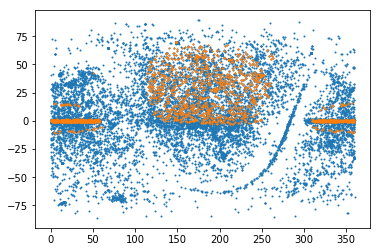

In [22]:
fig, ax = plt.subplots()
ax.scatter(oscgood['MEAN_RA'], oscgood['MEAN_DEC'], s=1)
#ax.scatter(oscra[oscmatch], oscdec[oscmatch], s=1)
ax.scatter(sdssinfo['RA'][indx_sdss], sdssinfo['DEC'][indx_sdss], s=1)

### Write out the matched catalogs.

In [23]:
oscout = oscgood[indx_osc]
oscout

Name,Disc. Date,mmax,Host Name,R.A.,Dec.,z,Type,Phot.,Spec.,Radio,X-ray,MEAN_RA,MEAN_DEC
str30,str21,float64,str30,str106,str146,str125,str19,float64,float64,float64,float64,float64,float64
PS17cab,2017/03/31,20.18,SDSS J094524.78+010337.2,"09:45:25.01,09:45:25.010","+01:03:28.90,+01:03:28.8",--,--,6.0,--,--,--,146.354208333,1.05801388889
PS17cab,2017/03/31,20.18,SDSS J094524.78+010337.2,"09:45:25.01,09:45:25.010","+01:03:28.90,+01:03:28.8",--,--,6.0,--,--,--,146.354208333,1.05801388889
SN2001kp,2001/03/21,18.2,A095153+0106,"09:51:53.064,09:51:53.04,09:51:53.00,09:51:53.08","+01:06:05.62,+01:06:05.76,+01:06:01.01,+01:06:05.8","0.063,0.0634",Ia,1.0,--,--,--,147.971025,1.10126319444
SN2001kr,2001/03/26,19.1,A095916+0058,"09:59:15.79,09:59:15.84,09:59:16.00,09:59:15.75","+00:58:02.8,+00:58:02.28,+00:58:00.01,+00:58:02.4","0.088,0.0882",Ia,1.0,--,--,--,149.816020833,0.967186805556
SN2013U,2013/01/05,16.45,PGC 29001,10:01:12.00,"+00:19:42.3,+00:19:42.31",0.03451,Ia Pec,24.0,7.0,--,--,150.3,0.328416666667
SN2016aws,2016/03/06,19.86,SDSS J101934.23-010033.6,"10:19:34.62,10:19:34.61","-01:00:32.62,-01:00:32.6","0.043,0.043",Ib,17.0,--,--,--,154.894229167,-1.00905833333
SN2000fx,2000/12/05,18.7,A101800-0001,"10:18:00.50,10:18:00.48,10:18:00.00,10:18:00.47","-00:01:58.5,-00:01:58.08,-00:01:59.99,-00:01:58.0","0.065,0.0652",Ia,1.0,--,--,--,154.501510417,-0.03295625
PS1-14av,2014/01/04,18.92,UGC 5528,10:14:39.24,-00:49:51.1,--,--,4.0,--,--,--,153.6635,-0.830861111111
PS15dkj,2015/12/09,20.97,SDSS J103353.80+000435.4,10:33:53.72,+00:04:37.3,--,--,11.0,--,--,--,158.473833333,0.0770277777778


In [24]:
sdssout = sdssinfo[indx_sdss].copy()
sdssout.add_columns(sdssprops[indx_sdss].columns.values())
sdssout

SPECOBJID,PLATEID,MJD,FIBERID,RA,DEC,Z,BPTCLASS,LGM_TOT_P50,OH_P50,SFR_TOT_P50,SPECSFR_TOT_P50
bytes19,int16,int32,int16,float32,float32,float32,int16,float32,float32,float32,float32
299634812510038016,266,51602,529,146.353,1.06037,0.127659,1,10.8837,8.96071,0.827367,-10.1132
299633163712358400,266,51630,523,146.353,1.06037,0.127619,1,10.8831,8.99778,0.879446,-10.0612
300740371552430080,267,51608,455,147.971,1.10164,0.0632417,2,10.6165,-9999.0,-0.504578,-11.1692
301898432593815552,268,51633,572,149.816,0.967329,0.0880019,3,10.2568,-9999.0,-0.228371,-10.5506
301905029663582208,268,51633,596,150.299,0.329321,0.0344885,1,10.4118,9.14995,0.537411,-9.91283
305133474874943488,271,51883,53,154.893,-1.00934,0.0432955,1,9.62503,8.56131,-0.157774,-9.84411
305165910467962880,271,51883,171,154.502,-0.0327748,0.0650882,-1,10.0978,-9999.0,-1.69094,-11.8285
305188175578425344,271,51883,252,153.665,-0.83091,0.0490197,4,11.5273,-9999.0,-0.810007,-12.3663
308582093598779392,274,51913,311,158.474,0.0765329,0.187105,2,10.789,-9999.0,0.108003,-10.7288


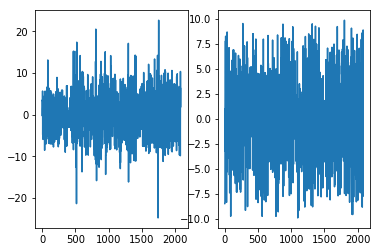

In [25]:
fig, ax = plt.subplots(1, 2)
ax[0].plot( (oscout['MEAN_RA'] - sdssout['RA']) * 3600 )
ax[1].plot( (oscout['MEAN_DEC'] - sdssout['DEC']) * 3600 )

In [26]:
sdssfile = 'galSpec-oscmatched.csv'
print('Writing {}'.format(sdssfile))
sdssout.write(sdssfile, format='csv', overwrite=True)

Writing galSpec-oscmatched.csv


In [27]:
oscfile = 'osc-galSpecmatched.csv'
print('Writing {}'.format(oscfile))
oscout.write(oscfile, format='csv', overwrite=True)

Writing osc-galSpecmatched.csv
